In [ ]:
import sys
sys.path.insert(0,"../")

In [2]:
from torch.utils.data import DataLoader
import torch


In [3]:
from core.model.model import MoCo
from core.dataloader import CLEVR_train, collate_boxes, CLEVR_train_onlyquery, collate_boxes_onlyquery
from core.utils import compute_features

In [4]:
kmeans_train_dataset = CLEVR_train_onlyquery(root_dir='/home/mprabhud/dataset/clevr_lang/npys/aa_5v.txt')
kmeans_train_loader = DataLoader(kmeans_train_dataset, batch_size=16, shuffle=False, collate_fn=collate_boxes_onlyquery)

Initialised..... 63  files...


In [5]:
for i, (feed_dict_q, metadata) in enumerate((kmeans_train_loader)):
    break

../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


In [6]:
model = MoCo()
model = model.cuda()

In [7]:
PATH = "../single_obj_exp_test/checkpoint.pth"
model.load_state_dict(torch.load(PATH)['state_dict'])

<All keys matched successfully>

In [8]:
from tqdm import tqdm

def compute_features(eval_loader, model, args):
    print('Computing features...')
    model.eval()
    features = torch.zeros(len(eval_loader.dataset),256).cuda()
    print(features.shape)
    for i, (feed_dict_q, metadata) in enumerate(tqdm(eval_loader)):
        with torch.no_grad():
            feat = model(feed_dict_q, None, metadata, is_eval=True)
            index = metadata['index']
            features[index] = feat
    return features.cpu()

In [9]:
features = compute_features(kmeans_train_loader, model, None)

  0%|          | 0/71 [00:00<?, ?it/s]

Computing features...
torch.Size([1134, 256])


../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)
100%|██████████| 71/71 [00:29<00:00,  2.37it/s]


In [10]:
import faiss

In [11]:
res = faiss.StandardGpuResources()
cfg = faiss.GpuIndexFlatConfig()
cfg.useFloat16 = False
cfg.device = 0   
index = faiss.GpuIndexFlatL2(res, 256, cfg)

In [12]:
index.add(features.numpy())

In [13]:
k = 10                          # we want 10 similar vectors
D, I = index.search(features.numpy(), k)     # actual search

In [14]:
I.shape

(1134, 10)

In [15]:
D.shape

(1134, 10)

In [16]:
#select some random 10 images
import random

In [17]:
random.seed(0)
anchor_indices = random.sample(range(0,I.shape[0]-1),10)

In [18]:
I[anchor_indices]

array([[ 788, 1040,  680,  782,  784,  681,  776, 1028, 1034, 1036],
       [ 861,  645,  852,  636,  642,  854,  858,  853,  638,  637],
       [  82,  712,  370,  982,  802,  424,  808,  988,  376,   88],
       [ 530,  529,  528,  533,  531,  532,  539,  534,  525,  526],
       [1047,  327,  331, 1051, 1049, 1057,  337,  334,  328,  335],
       [ 995,  149,  148,  994, 1001,  155,  991,  145, 1007,  161],
       [ 829,  833,  843,  834,  831,  836,  837,  830,  844,  838],
       [ 621,  135,  585,  133,  141,  629,  625,  627,  593,  137],
       [ 976,  796,  364,   76,  706,  418,   80,  710,  368,  794],
       [ 733,  735,  737,  736,  734,  732,  730,  729,  726,  731]])

In [49]:
selected = I[anchor_indices]

In [20]:
import matplotlib.pyplot as plt

In [38]:
def get_image(i):
    return (kmeans_train_dataset[i][0].permute(1,2,0))

In [45]:
I[96]

array([ 96, 600, 906, 604, 595, 100, 598,  91, 601,  94])

[ 788 1040  680  782  784  681  776 1028 1034 1036]


../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


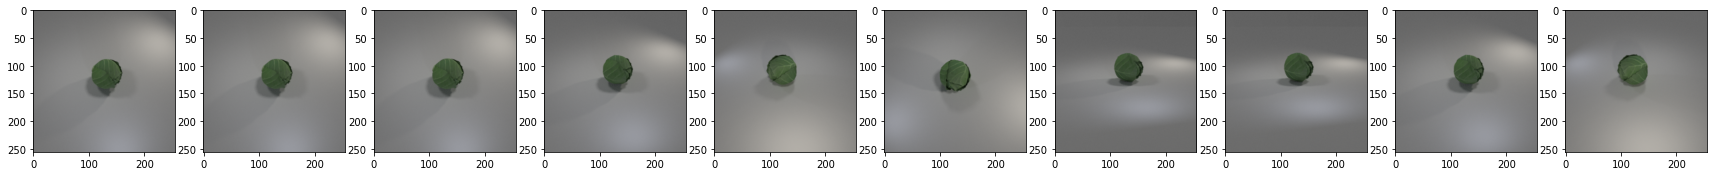

[861 645 852 636 642 854 858 853 638 637]


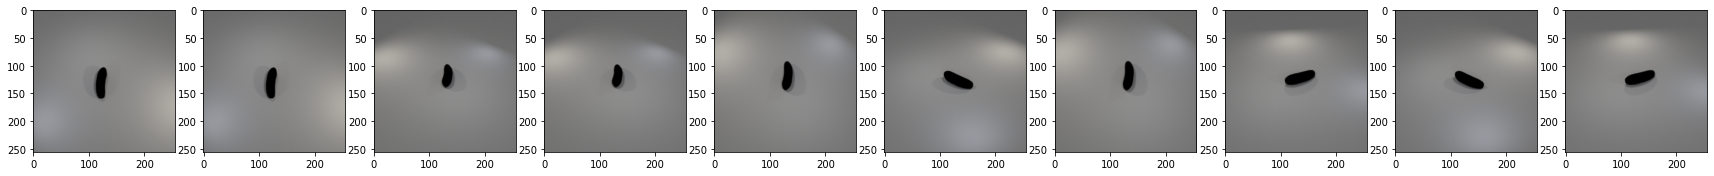

[ 82 712 370 982 802 424 808 988 376  88]


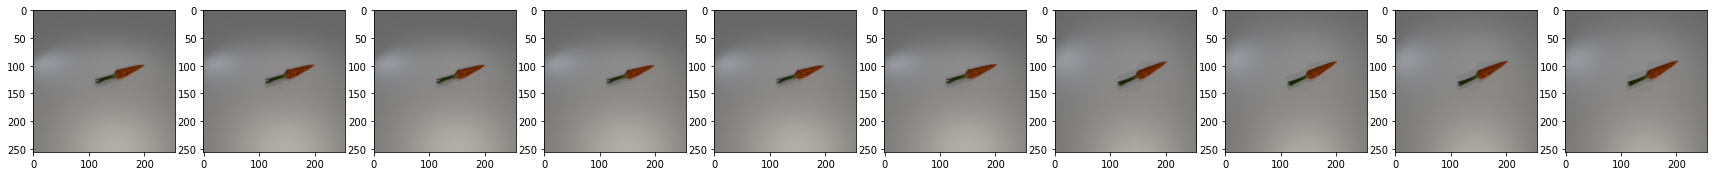

[530 529 528 533 531 532 539 534 525 526]


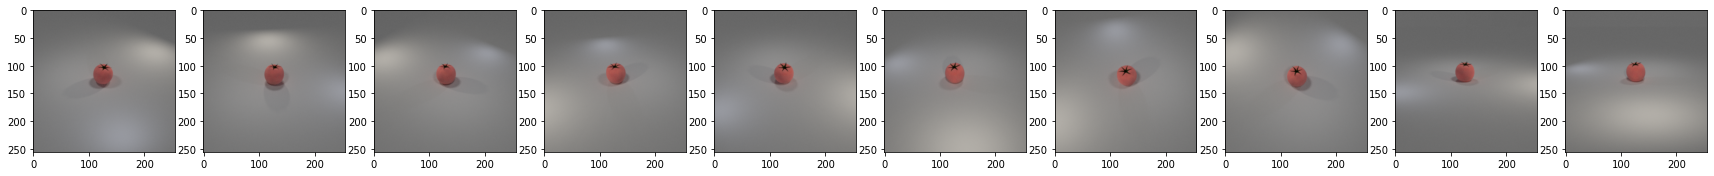

[1047  327  331 1051 1049 1057  337  334  328  335]


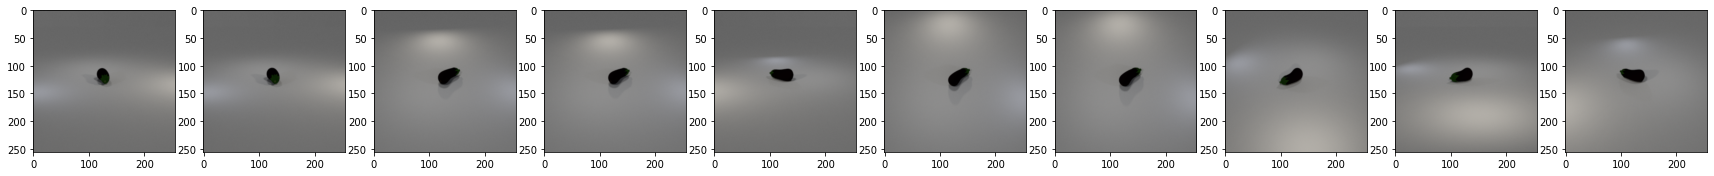

[ 995  149  148  994 1001  155  991  145 1007  161]


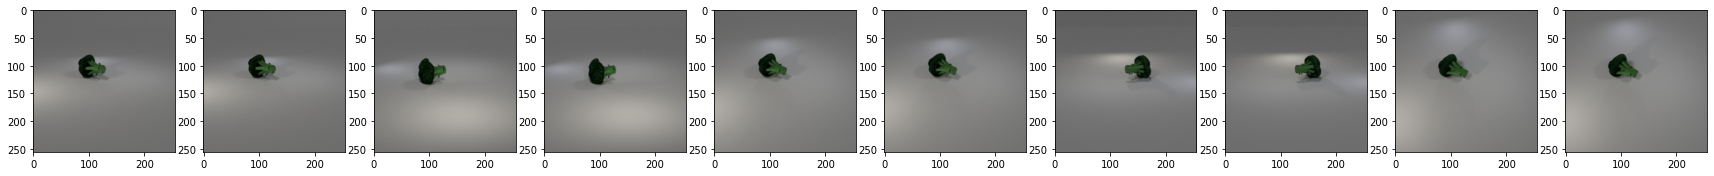

[829 833 843 834 831 836 837 830 844 838]


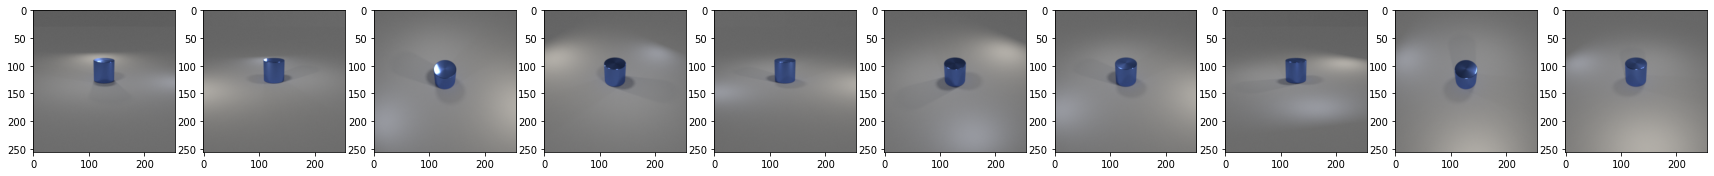

[621 135 585 133 141 629 625 627 593 137]


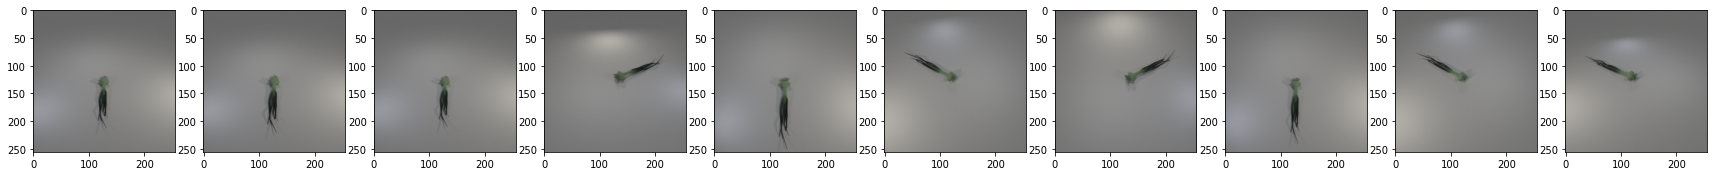

[976 796 364  76 706 418  80 710 368 794]


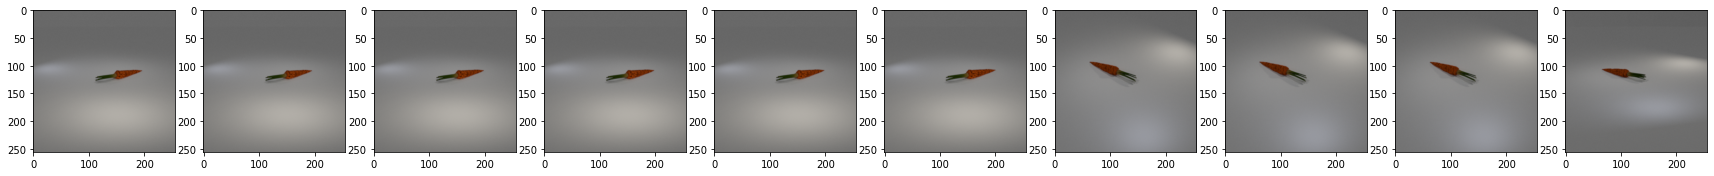

[733 735 737 736 734 732 730 729 726 731]


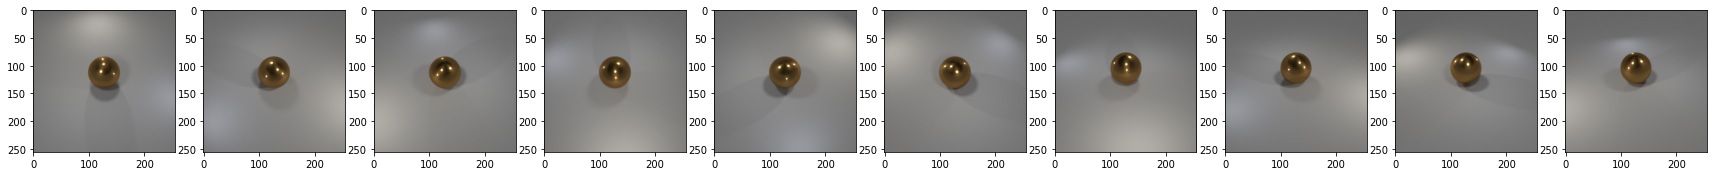

In [53]:
for i in range(len(selected)):

    fig = plt.figure(figsize=(30,30))
    ax = []
    
    print(selected[i])
    for j in range(1,11):
        ax.append(fig.add_subplot(1,10,j))
        plt.imshow(get_image(selected[i][j-1]))

    plt.show()

../core/utils_disco.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xmin,ymin,zmin,xmax,ymax,zmax = torch.unbind(torch.tensor(aligned_boxes), dim=-1)


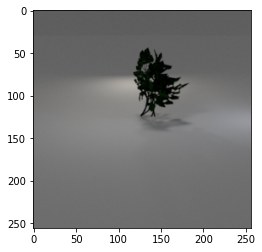

In [48]:
plt.imshow(get_image(595))